### Load the libraries

In [89]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
%matplotlib inline

### Show images

In [90]:
def show_images(image1, title1, image2, title2):
    image1 = cv2.imread(image1)
    image2 = cv2.imread(image2)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [91]:
def get_dataset(rootdir):
    images = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if '.DS_Store' not in file:
                images.append(os.path.join(subdir, file))
    return images

In [92]:
rootdir = './dataset/vehicles'
vehicles = get_dataset(rootdir)

In [93]:
rootdir = './dataset/non-vehicles'
non_vehicles = get_dataset(rootdir)

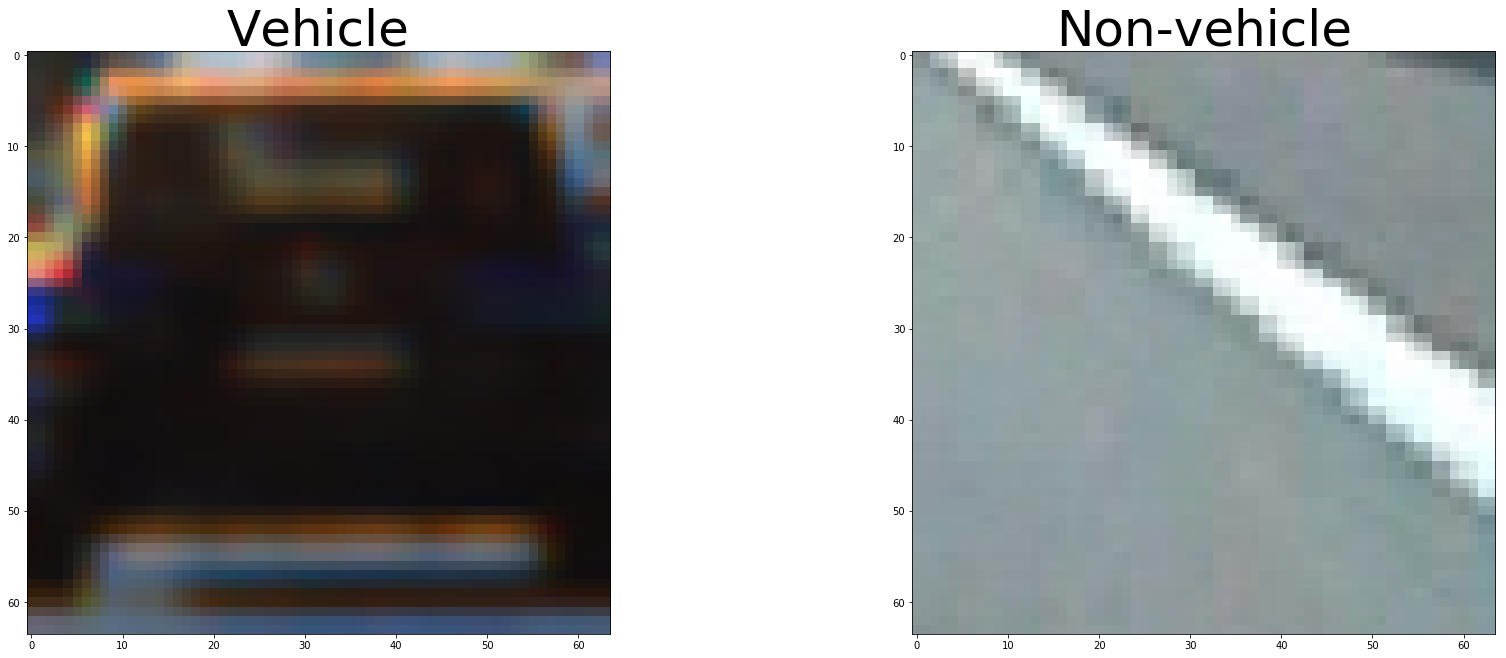

In [94]:
image1 = random.choice(vehicles)
image2 = random.choice(non_vehicles)
show_images(image1, "Vehicle", image2, "Non-vehicle")

### Binned color features 

In [95]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    # Return the feature vector
    return features


### Color histogram features 

In [96]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### HOG features

In [169]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Extract features from a list of images

In [170]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [171]:
class Parameters():
    def __init__(self):
        # HOG parameters
        self.color_space = 'RGB'
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        self.spatial_size = (16, 16)
        self.hist_bins = 32
        self.ystart = 400
        self.ystop = 656
        self.scale = 1.5

In [172]:
params = Parameters()

### Show Hog features

In [173]:
def show_hog(vehicle, non_vehicle):
    vehicle = cv2.cvtColor(vehicle, cv2.COLOR_BGR2RGB)
    non_vehicle = cv2.cvtColor(non_vehicle, cv2.COLOR_BGR2RGB)
    _,vehicle_hog = get_hog_features(vehicle[:,:,0],params.orient, params.pix_per_cell, params.cell_per_block, vis=True, feature_vec=True)
    _,non_vehicle_hog = get_hog_features(non_vehicle[:,:,0],params.orient, params.pix_per_cell, params.cell_per_block, vis=True, feature_vec=True)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
    ax1.set_title('Vehicle')
    ax1.imshow(vehicle, cmap='gray')
    ax2.set_title('Vehicle hog')
    ax2.imshow(vehicle_hog, cmap='gray')
    ax3.set_title('Non-vehicle')
    ax3.imshow(non_vehicle, cmap='gray')
    ax4.set_title('Non-vehicle hog')
    ax4.imshow(non_vehicle_hog, cmap='gray')

/Users/dhanoopkarunakaran/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


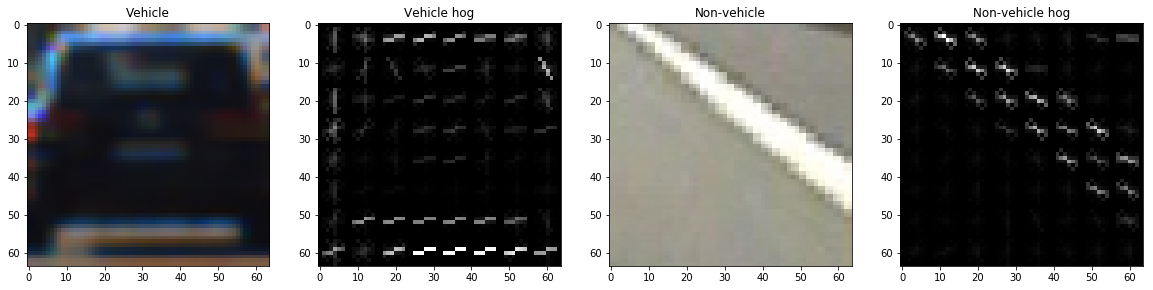

In [174]:
vehicle = cv2.imread(image1)
non_vehicle = cv2.imread(image2)
show_hog(vehicle, non_vehicle)

### SVM

In [187]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 8750
cars = vehicles[0:sample_size]
notcars = non_vehicles[0:sample_size]

### Tweak these parameters and see how the results change.
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 700] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=params.color_space, 
                        spatial_size=params.spatial_size, hist_bins=params.hist_bins, 
                        orient=params.orient, pix_per_cell=params.pix_per_cell, 
                        cell_per_block=params.cell_per_block, 
                        hog_channel=params.hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=params.color_space, 
                        spatial_size=params.spatial_size, hist_bins=params.hist_bins, 
                        orient=params.orient, pix_per_cell=params.pix_per_cell, 
                        cell_per_block=params.cell_per_block, 
                        hog_channel=params.hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

/Users/dhanoopkarunakaran/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
18.91 Seconds to train SVC...
Test Accuracy of SVC =  0.9769


### Define a single function that can extract features using hog sub-sampling and make predictions

In [188]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)
            features = extract_features(subimg, color_space=params.color_space, 
                        spatial_size=params.spatial_size, hist_bins=params.hist_bins, 
                        orient=params.orient, pix_per_cell=params.pix_per_cell, 
                        cell_per_block=params.cell_per_block, 
                        hog_channel=params.hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
            # Scale features and make a prediction
            test_features = X_scaler.transform(features.reshape(1, -1))   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [189]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = find_cars(img, params.ystart, params.ystop, params.scale, svc, X_scaler, params.orient, params.pix_per_cell, params.cell_per_block, params.spatial_size, params.hist_bins)
plt.imshow(out_img)

/Users/dhanoopkarunakaran/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


TypeError: Object does not appear to be a 8-bit string path or a Python file-like object